In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import pickle
import matplotlib.pyplot as plt

In [2]:
def load_model(file_path):
    with open(file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    return model


In [3]:
def get_real_time_node_status(data, model):
    # Dự đoán bất thường
    data['anomaly'] = model.predict(data[['ph', 'tds']])
    # Các node bị ô nhiễm
    polluted_nodes = data[data['anomaly'] == -1]
    # Sử dụng DBSCAN để tìm các cụm bất thường
    db = DBSCAN(eps=1.5, min_samples=2).fit(data[['ph', 'tds']])
    data['cluster'] = db.labels_
    # Tìm các node bị ảnh hưởng (nằm trong cùng cụm với các node bị ô nhiễm)
    affected_nodes = []
    for node_id in polluted_nodes['node_id'].unique():
        node_cluster = data[data['node_id'] == node_id]['cluster'].iloc[0]
        if node_cluster != -1:
            affected_nodes.extend(data[data['cluster'] == node_cluster]['node_id'].unique())
    # Loại bỏ trùng lặp
    affected_nodes = list(set(affected_nodes))
    # Loại bỏ các node bị ô nhiễm ra khỏi danh sách bị ảnh hưởng
    affected_nodes = [node for node in affected_nodes if node not in polluted_nodes['node_id'].unique()]
    # Các node bình thường
    normal_nodes = data[data['anomaly'] == 1]['node_id'].unique()
    normal_nodes = [node for node in normal_nodes if node not in affected_nodes]
    return {
        'polluted_nodes': polluted_nodes['node_id'].unique().tolist(),
        'affected_nodes': affected_nodes,
        'normal_nodes': normal_nodes
    }


In [4]:
optimized_clf = load_model('optimized_clf.pkl')

In [5]:
real_time_data = pd.DataFrame({
    'node_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'ph': [7.0, 7.1, 7.2, 7.1, 7.0, 7.1, 7.0, 7.5, 8.0, 10.5],
    'tds': [300, 310, 320, 315, 300, 305, 300, 350, 400, 550],
    'time': ['2024-06-01 00:00:00'] * 10
})
real_time_status = get_real_time_node_status(real_time_data, optimized_clf)

print("Nodes bị ô nhiễm:", real_time_status['polluted_nodes'])
print("Nodes bị ảnh hưởng:", real_time_status['affected_nodes'])
print("Nodes bình thường:", real_time_status['normal_nodes'])


Nodes bị ô nhiễm: [9, 10]
Nodes bị ảnh hưởng: []
Nodes bình thường: [1, 2, 3, 4, 5, 6, 7, 8]


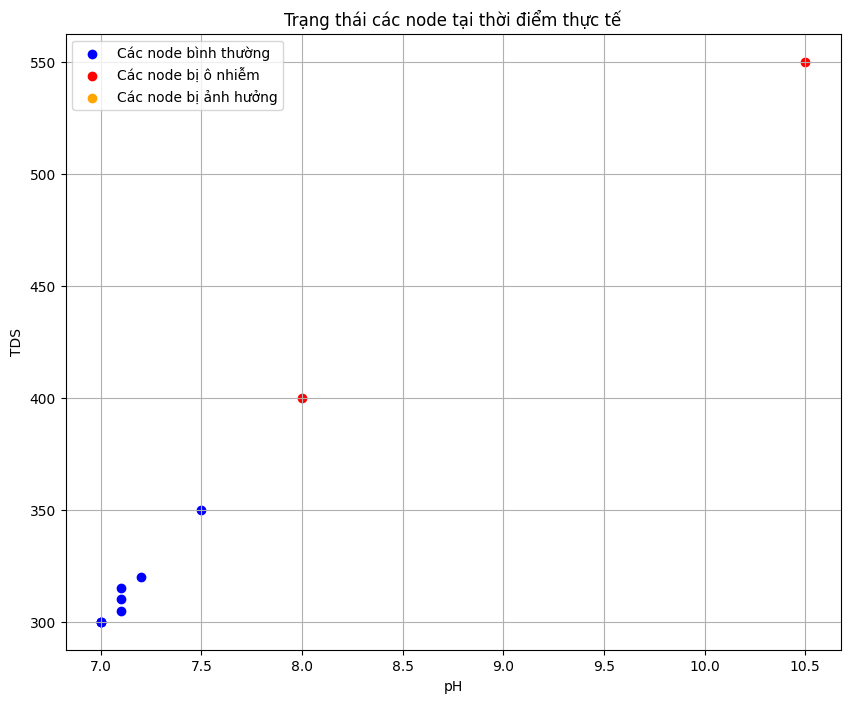

In [6]:
def plot_real_time_node_status(real_time_data, real_time_status):
    plt.figure(figsize=(10, 8))
    plt.scatter(real_time_data[real_time_data['node_id'].isin(real_time_status['normal_nodes'])]['ph'], 
                real_time_data[real_time_data['node_id'].isin(real_time_status['normal_nodes'])]['tds'], 
                color='blue', label='Các node bình thường')
    plt.scatter(real_time_data[real_time_data['node_id'].isin(real_time_status['polluted_nodes'])]['ph'], 
                real_time_data[real_time_data['node_id'].isin(real_time_status['polluted_nodes'])]['tds'], 
                color='red', label='Các node bị ô nhiễm')
    plt.scatter(real_time_data[real_time_data['node_id'].isin(real_time_status['affected_nodes'])]['ph'], 
                real_time_data[real_time_data['node_id'].isin(real_time_status['affected_nodes'])]['tds'], 
                color='orange', label='Các node bị ảnh hưởng')
    plt.xlabel('pH')
    plt.ylabel('TDS')
    plt.title(f'Trạng thái các node tại thời điểm thực tế')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the status of nodes in real-time
plot_real_time_node_status(real_time_data, real_time_status)